# Topic Modeling: Depression

### The first step is importing the packages that we will be using for identifying topic models.

In [1]:
# Import required packages

# DATA PREPROCESSING
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import Phrases

# MODELING
import sklearn
import re
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from numpy import array

# VISUALIZATION
import matplotlib.pyplot as plt
import seaborn as sns
import pyLDAvis
import pyLDAvis.gensim
import pickle 

# OTHER
import numpy as np
import pandas as pd
import logging
import json
import warnings
import random

warnings.filterwarnings('ignore')  

### In the second step, we read the dataset, and take a glance at what it looks like.

In [2]:
data = pd.read_csv('depression.csv')

In [3]:
data.head()

,user_ID,followers_count,user_location,user_description,date,text,hashtags
0,1.390000e+18,53,"Barcelona, Spain","For 34 years, Psych Congress has served as a u...",10/27/2021 11:45,Extended abstract submission deadline is TODAY...,NaN
1,2.350451e+09,30626,"Sacramento, California",Believer in creating a healthy game plan to fe...,10/27/2021 11:39,"🌟This Fall and if you can, intentionally spend...",['anxiety']
2,3.345540e+09,829,"Pittsburgh, PA","Founder Motivation Champs, Publisher 📚, Screen...",10/27/2021 11:38,Proud to welcome Stephanie Kunkel to the Motiv...,NaN
3,1.174093e+07,3089,"Toronto, Canada",Self healing journey from ✝️ trauma to spiritu...,10/27/2021 11:35,How much energy do you put into keeping up app...,['travelblogger']
4,4.008473e+09,417,"London, England",rTMS treatment across the UK and Ireland.\r\r\...,10/27/2021 11:35,Did you know that we treat seasonal affective ...,"['seasonalaffectivedisorder', 'SAD']"


### Then, we extract our column of interest, which is the tweet.

In [4]:
tweets = data['text']

### Once we have the tweets, we pre-process the data to make it ready for analysis.

Initially, we convert everything to lowercase, and then we remove users, links, punctuation, double spaces, numbers, short words, emojis and stopwords.

Then, we tokenize each word, splitting the sentences in separate words.

Lasly, we convert each word into their lemmas (the form of a word under which it is registered in a dictionary).

In [5]:
# list of commonly repeated words that do not add meanings
my_stopwords = nltk.corpus.stopwords.words('english')
repeated_words = ['ever', 'start', 'pre', '&amp', 
                  'amp', 'may', 'and', 'when',
                  'what','who', 'why','how', 
                  'this', 'your', 'mine', 'their',
                  'her', 'his', 'that', 'mental']

for i in repeated_words:
    my_stopwords.append(i)
    
tweets = tweets.apply(lambda x: ' '.join([word for word in x.split() if word not in (my_stopwords)]))
tweets = array(tweets)
    
# list of common punctuation    
my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`’{|}~•@'

# list of the majority of emojis
emoj = re.compile("["  
    u"\U0001F600-\U0001F64F" 
    u"\U0001F300-\U0001F5FF" 
    u"\U0001F680-\U0001F6FF"  
    u"\U0001F1E0-\U0001F1FF"  
    u"\U00002500-\U00002BEF"  
    u"\U00002702-\U000027B0"
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    u"\U0001f926-\U0001f937"
    u"\U00010000-\U0010ffff"
    u"\u2640-\u2642" 
    u"\u2600-\u2B55"
    u"\u200d"
    u"\u23cf"
    u"\u23e9"
    u"\u231a"
    u"\ufe0f"  
    u"\u3030"
                  "]+", re.UNICODE) 

In [6]:
def preprocessor(tweets):
    """
    Removes unnecessary information from tweets,
    and lemmatizes the tweets.

    Input(s):
    ------------------------------
    tweets(array): all original tweets
    
    Output(s):
    ------------------------------
    tweets(array): cleaned up and lemmatized tweets
    """
    tokenizer = RegexpTokenizer(r'\w+')
    for idx in range(len(tweets)):       
        tweets[idx] = re.sub(r'http\S+', '', tweets[idx]) # http links
        tweets[idx] = re.sub(r'bit.ly/\S+', '', tweets[idx]) # bitly links
        tweets[idx] = tweets[idx].strip('[link]') # other links(i.e. gifs)
        tweets[idx] = tweets[idx].lower()  # turn to lowercase
        tweets[idx] = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweets[idx]) # retweets
        tweets[idx] = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweets[idx]) # tweeted at
        tweets[idx] = re.sub ('#', '', tweets[idx]) # hashtags
        tweets[idx] = re.sub(emoj, '', tweets[idx]) # emojis
        tweets[idx] = re.sub('['+my_punctuation + ']+', ' ', tweets[idx]) # remove punctuation
        tweets[idx] = re.sub('\s+', ' ', tweets[idx]) # remove double spacing
        tweets[idx] = tokenizer.tokenize(tweets[idx])   # split into words


    # numbers (but not words with number)
    tweets = [[token for token in tweet if not token.isdigit()] for tweet in tweets]
    
    # words that are only one character
    tweets = [[token for token in tweet if len(token) > 3] for tweet in tweets]
    
    tweets = [[token for token in tweet if len(token) > 3] for tweet in tweets]
    
    # lemmatize all words in documents
    lemmatizer = WordNetLemmatizer()
    tweets = [[lemmatizer.lemmatize(token) for token in tweet] for tweet in tweets]
 
    return tweets

In [7]:
tweets = preprocessor(tweets)

### We also create bi- and trigrams, and remove words that appear rarely. This is words that occurr frequently together, for example "more_than, less_than".

In [8]:
# add bigrams and trigrams to docs

# only add bi/trigrams that appear > 10 times
bigram = Phrases(tweets, min_count=10)
trigram = Phrases(bigram[tweets])

for idx in range(len(tweets)):
    for token in bigram[tweets[idx]]:
        if '_' in token:
            tweets[idx].append(token)
    for token in trigram[tweets[idx]]:
        if '_' in token:
            tweets[idx].append(token)

dictionary = Dictionary(tweets)
dictionary.filter_extremes(no_below=10, no_above=0.2)

corpus = [dictionary.doc2bow(t) for t in tweets]

### After being ready for analysis, we analyze this data with Latent Dirichlet Allocation model by assigning a random number of topics.

In [9]:
num_topics = 5 # number of topics

temp = dictionary[0] 
id2word = dictionary.id2token

lda_model = LdaModel(corpus=corpus, id2word=id2word, chunksize=400, \
                       alpha='auto', eta='auto', \
                       iterations=20, num_topics=num_topics, \
                       passes=20, eval_every=1)

# show keywords
print(lda_model.print_topics())

[(0, '0.059*"online" + 0.057*"online_mindfulness" + 0.048*"therapy" + 0.035*"mindfulness" + 0.026*"depressiontreatment_depressionrecovery" + 0.022*"contact_learn" + 0.021*"onlinetherapy_onlinetherapist" + 0.019*"mindfulness_therapy" + 0.018*"contact" + 0.015*"overcoming"'), (1, '0.091*"really_help" + 0.090*"research_find" + 0.060*"acupuncture" + 0.060*"evidence_back" + 0.060*"beneficial_good" + 0.060*"performance_always" + 0.039*"really" + 0.038*"research" + 0.038*"find" + 0.037*"back"'), (2, '0.103*"study" + 0.103*"disorder" + 0.102*"mentalhealthmatters" + 0.102*"world" + 0.101*"major" + 0.101*"increase" + 0.100*"published" + 0.100*"million" + 0.057*"pandemic" + 0.013*"study_published"'), (3, '0.138*"million_case" + 0.138*"disorder_pandemic" + 0.092*"wide_increase" + 0.092*"lancet_october" + 0.092*"document_world" + 0.086*"study_published" + 0.046*"october" + 0.046*"wide" + 0.046*"document" + 0.046*"lancet"'), (4, '0.016*"health" + 0.015*"help" + 0.012*"mentalhealthawareness" + 0.011*

### We check the accuracy of our model with coherence scores (through CV, and UMass).

High values of c_v and low values of UMass indicate higher accuracy.

In [10]:
# coherence score (c_v)
coherence_model_cv = CoherenceModel(model=lda_model, texts=tweets, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model_cv.get_coherence()
print('\nCoherence Score: ', coherence_score)


Coherence Score:  0.5612748125367043


In [11]:
coherence_model_cv = CoherenceModel(model=lda_model, texts=tweets, dictionary=dictionary, coherence='u_mass')
coherence_score = coherence_model_cv.get_coherence()
print('\nCoherence Score: ', coherence_score)


Coherence Score:  -7.6218310337195945


### To determine the ideal number of topics, we run a simulation with different number of topics and keep track of the coherence scores.

In [12]:
def simulate_coherence_values(dictionary, corpus, texts, limit=11):
    """
    Simulate c_v for multiple LDA models with different number of topics.

    Input:
    ----------
    dictionary (dict) : gensim dictionary
    corpus (list): gensim corpus
    texts (list): list of input texts
    limit (int): maximum number of topics

    Output:
    -------
     coherence_scores : coherence scores corresponding to the LDA model with respective number of topics
    """
    coherence_scores = []
    models = []
    for num_topics in range(2,limit):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_scores.append(coherencemodel.get_coherence())
        models.append(model)

    return coherence_scores, models

In [13]:
coherence_values, models = simulate_coherence_values(dictionary=dictionary, corpus=corpus, texts=tweets)

In [14]:
coherence_values

[0.6008030277111318,
 0.6718798271467654,
 0.7535811564035169,
 0.737542540143336,
 0.4986645613970846,
 0.43723662564726273,
 0.5155404501978307,
 0.5600260115382594,
 0.5670587909084681]

In [15]:
# pick the best model, with the highest coherence score
best_model = models[(coherence_values.index(max(coherence_values)))]

### We plot the results of the simulation and find out that the ideal number of topics is 4.

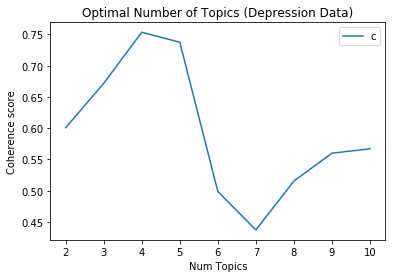

In [16]:
limit=11; start=2; 
x = range(start, limit)
plt.plot(x, coherence_values)
plt.title('Optimal Number of Topics (Depression Data)')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

### Once we have the weights and frequency of topic words, we are able to visualize the topics.

In [17]:
# visualize the topics
pyLDAvis.enable_notebook()
LDAvis_viz = pyLDAvis.gensim.prepare(best_model, corpus, dictionary)
LDAvis_viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.234548  0.202469       1        1  37.452074
1      0.358777  0.040743       2        1  35.958979
3     -0.108265 -0.314062       3        1  13.339771
2     -0.015964  0.070850       4        1  13.249176, topic_info=                                Term         Freq        Total Category  \
term                                                                      
839                      really_help  7285.000000  7285.000000  Default   
1197                    million_case  6330.000000  6330.000000  Default   
1196               disorder_pandemic  6321.000000  6321.000000  Default   
684                             wide  3573.000000  3573.000000  Default   
1210                   research_find  6573.000000  6573.000000  Default   
1175                    live_podcast  2182.000000  2182.000000  Default   
1195                 study_published  4226.000000  4226.000000  Default   
1207                   evidence_back  4381.000000  4381.000000  Default   
1209              performance_always  4381.000000  4381.000000  Default   
1202                 beneficial_good  4381.000000  4381.000000  Default   
1201                     acupuncture  4383.000000  4383.000000  Default   
1176                     quote_radio  1458.000000  1458.000000  Default   
78                              find  2657.000000  2657.000000  Default   
935                       beneficial  2421.000000  2421.000000  Default   
1229                   wide_increase  3977.000000  3977.000000  Default   
1227                  lancet_october  3977.000000  3977.000000  Default   
1225                  document_world  3977.000000  3977.000000  Default   
171                             live  1084.000000  1084.000000  Default   
571                         research  2598.000000  2598.000000  Default   
1071                       published  2123.000000  2123.000000  Default   
465                            quote  1007.000000  1007.000000  Default   
1224                        document  2112.000000  2112.000000  Default   
262                             case  2119.000000  2119.000000  Default   
591                            major  2135.000000  2135.000000  Default   
1190                          lancet  2111.000000  2111.000000  Default   
159                          podcast   956.000000   956.000000  Default   
75                              back  2510.000000  2510.000000  Default   
7                              world  2508.000000  2508.000000  Default   
62                            always  2464.000000  2464.000000  Default   
274                         evidence  2304.000000  2304.000000  Default   
...                              ...          ...          ...      ...   
49                            online   236.967290   458.384545   Topic4   
248                          thought    83.945797   114.864326   Topic4   
211                            going    85.272933   117.558065   Topic4   
66                             never    77.714659   103.872878   Topic4   
7                              world   639.815505  2508.773591   Topic4   
39                           therapy   209.773144   463.827656   Topic4   
168                             care    94.478161   140.153724   Topic4   
68                           someone   100.726857   156.960413   Topic4   
129                             love   131.826614   247.518083   Topic4   
55             mentalhealthawareness   138.595629   307.295299   Topic4   
380                          bipolar   110.492614   209.483635   Topic4   
43                              know   103.780705   201.524447   Topic4   
1225                  document_world   373.157035  3977.650458   Topic4   
1227                  lancet_october   373.157035  3977.650458   Topic4   
1229                   wide_increase   373.157035  3977.650458   Topic4   
120                      mindfuln

### We interpret the topics based on the keywords.

In [34]:
print('1: Studies/Publications/Stats')
print('2: Treatment Research/Experience')
print('3: Mediums/Trends')
print('4: Therapy/Symptoms')

1: Studies/Publications/Stats
2: Treatment Research/Experience
3: Mediums/Trends
4: Therapy/Symptoms


### Finally, we label the data and save it.

In [35]:
cat_name = ['Studies/Publications/Stats', 'Treatment Research/Experience', 'Mediums/Trends', 'Therapy/Symptoms']

def add_labels(model=best_model, corpus=corpus, data=data):
    # get main topic in each document
    topics = []
    categories = []
    for i, row in enumerate(model[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # dominant topic
                wp = model.show_topic(topic_num)
                topics.append(topic_num+1)
                categories.append(cat_name[topic_num])
            else:
                break
    data['category'] = categories
    data['class'] = topics
    return data.reset_index()

In [36]:
data_labelled = add_labels(model=best_model, corpus=corpus, data=data)

In [37]:
data_labelled.category.describe()

count                          16733
unique                             4
top       Studies/Publications/Stats
freq                           10090
Name: category, dtype: object

In [38]:
data_labelled['class'].unique()

array([1, 3, 2, 4], dtype=int64)

In [39]:
data.head()

,user_ID,followers_count,user_location,user_description,date,text,hashtags,category,class
0,1.390000e+18,53,"Barcelona, Spain","For 34 years, Psych Congress has served as a u...",10/27/2021 11:45,Extended abstract submission deadline is TODAY...,NaN,Studies/Publications/Stats,1
1,2.350451e+09,30626,"Sacramento, California",Believer in creating a healthy game plan to fe...,10/27/2021 11:39,"🌟This Fall and if you can, intentionally spend...",['anxiety'],Mediums/Trends,3
2,3.345540e+09,829,"Pittsburgh, PA","Founder Motivation Champs, Publisher 📚, Screen...",10/27/2021 11:38,Proud to welcome Stephanie Kunkel to the Motiv...,NaN,Mediums/Trends,3
3,1.174093e+07,3089,"Toronto, Canada",Self healing journey from ✝️ trauma to spiritu...,10/27/2021 11:35,How much energy do you put into keeping up app...,['travelblogger'],Studies/Publications/Stats,1
4,4.008473e+09,417,"London, England",rTMS treatment across the UK and Ireland.\r\r\...,10/27/2021 11:35,Did you know that we treat seasonal affective ...,"['seasonalaffectivedisorder', 'SAD']",Treatment Research/Experience,2


In [40]:
for i in range(5):
    random_tweet = random.randint(1,len(data))
    print('Tweet:', data.text[random_tweet])
    print('************************************************************')
    print('Category:', data.category[random_tweet])
    print('--------------------------------------------------------------------------------------------------------------------------------')

Tweet: A new study published in the Lancet on 8 October 2021 documents a world-wide increase of more than 129 million cases of major #depression (53.2mn) and #anxiety (76.2mn) disorders during the #pandemic https://t.co/2ZrVYEY9sX #MentalHealthMatters https://t.co/x2MeI2XNIz
************************************************************
Category: Studies/Publications/Stats
--------------------------------------------------------------------------------------------------------------------------------
Tweet: A new study published in the Lancet on 8 October 2021 documents a world-wide increase of more than 129 million cases of major #depression (53.2mn) and #anxiety (76.2mn) disorders during the #pandemic https://t.co/2ZrVYEY9sX #MentalHealthMatters https://t.co/x2MeI2XNIz
************************************************************
Category: Studies/Publications/Stats
---------------------------------------------------------------------------------------------------------------------------

In [41]:
data.to_csv('Depression with TM labels.csv')